# ぷれいちゅうでどれくらい取れているかを計測

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

sys.path.append('/home/mei/Documents/deep_sort/exp/20220609/utils')

from utils.frame import sec2frame
from utils.load_data import (load_annotated_trackret_file,
                             get_player_id_list,
                             load_pose_data,
                             load_bbox_data
                            )
from utils.matching import match_id_by_iou
from IPython.core.debugger import Pdb
import multiprocessing
from multiprocessing import Manager, Process
from tqdm.notebook import tqdm

In [2]:
ist = Pdb().set_trace

In [3]:
data_file_path = Path(os.getcwd())/'data'
data_name = data_file_path / 'p008_wtnb_0528.csv'

In [4]:
df = pd.read_csv(data_name)
df.head()

,start,end,labels
0,77.761265,77.861253,OA
1,78.395459,78.470450,XB
2,78.978720,79.045378,XA
3,79.561053,79.602715,OB
4,91.541977,91.583639,OA


In [5]:
df['start_frame']=df['start'].apply(sec2frame)
df.head()

,start,end,labels,start_frame
0,77.761265,77.861253,OA,2330
1,78.395459,78.470450,XB,2349
2,78.978720,79.045378,XA,2366
3,79.561053,79.602715,OB,2384
4,91.541977,91.583639,OA,2743


<AxesSubplot:>

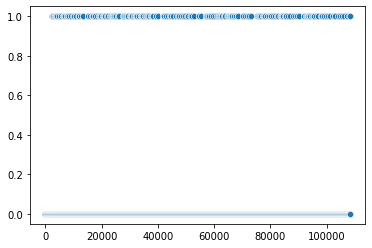

In [6]:
tmp = df.copy()
max_frame = df['start_frame'].max()+1
height = [1  if i in df['start_frame'].to_numpy() else 0 for i in range(max_frame)]
x = [i for i in range(max_frame)]

sns.scatterplot(x=x,y=height)

/home/mei/.pyenv/versions/3.6.8/envs/gmtracker/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


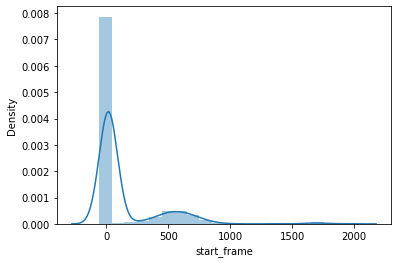

In [7]:
df_diff=df['start_frame'].diff()
sns.distplot(df_diff,bins=20)
plt.show()

In [8]:
def OtsuScore(data,thresh):
    """前後のプレーの時間差から閾値となる二値を決める"""
    w_0 = len(data[data > thresh])/len(data)
    w_1 = len(data[data <= thresh])/len(data)
    
    if w_0== 0 or w_1==0:
        return 0
    mean_all = data.mean()
    mean_0 = data[data>thresh].mean()
    mean_1 = data[data<=thresh].mean()
    
    sigma = w_0*((mean_0-mean_all)**2) + w_1*((mean_1-mean_all)**2)
    return sigma

iters = 20000
scores = [0] * iters
for i in range(iters):
    scores[i] = OtsuScore(df_diff,i)

print(max(scores))

60453.87752803594


330


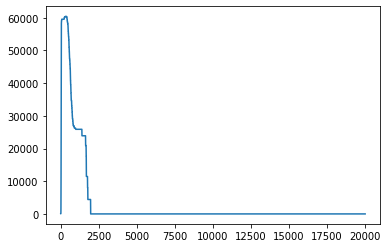

In [9]:
plt.plot(scores)
print(scores.index(max(scores)))

In [10]:
threshold = min(scores.index(max(scores)),50)
print(df_diff[df_diff>threshold].shape,df_diff[df_diff<=threshold].shape)

(155,) (592,)


In [11]:
cnt = 0
df = df.reset_index(drop=True)
df['df_diff'] = df_diff
df.loc[0,'group']=0
for i in range(1,len(df)):
    if df.loc[i,'df_diff']>=threshold:
        cnt += 1
    df.loc[i,'group'] = cnt
df.head()


,start,end,labels,start_frame,df_diff,group
0,77.761265,77.861253,OA,2330,NaN,0.0
1,78.395459,78.470450,XB,2349,19.0,0.0
2,78.978720,79.045378,XA,2366,17.0,0.0
3,79.561053,79.602715,OB,2384,18.0,0.0
4,91.541977,91.583639,OA,2743,359.0,1.0


In [12]:
df.groupby('group')['start_frame'].apply(lambda x: x.max()-x.min())

group
0.0      54
1.0      62
2.0      70
3.0      49
4.0      52
         ..
151.0    59
152.0    30
153.0    55
154.0    88
155.0    63
Name: start_frame, Length: 156, dtype: int64

## トラックレットを結合する

In [13]:
tracklet_name = data_file_path / 'p008_annotated_tracklet.csv'
tracklet = pd.read_csv(tracklet_name)
tracklet.head()

,frame,player1,player2
0,3.0,3,2
1,15.0,3,2
2,114.0,6,2
3,190.0,6,2
4,232.0,10,2


In [14]:
max_frame = 109275 +1 
all_df = pd.DataFrame({'frame':list(range(max_frame))})
all_df = pd.merge(all_df,tracklet,on='frame',how='left')
all_df = pd.merge(all_df,df[['start_frame','group']],left_on='frame',right_on='start_frame',how='left').drop(columns='start_frame')
all_df['group'] = all_df['group'].fillna(method='ffill')

## トラックレットとkapaoidを組み合わせる

In [15]:
tracklet_df = load_annotated_trackret_file(tracklet_name)
player1_tracklet, player2_tracklet = get_player_id_list(tracklet_df)
video_name='p008'
pose_path=f"/home/mei/Documents/deep_sort/exp/20220512/data/detection_poses_{video_name}.pkl"
pose_data=load_pose_data(pose_path)
bbox_path=bbox_path=f"/home/mei/Documents/deep_sort/exp/20220512/data/{video_name}/{video_name}_deepsort_output.txt"
bbox_list: list= load_bbox_data(bbox_path)

In [16]:
tracklet_df
player1_tracklet
pose_data[0]
bbox_list[0]

[3, 1, 1674.26, 386.02, 243.47, 445.98, 1, -1, -1, -1]

In [17]:

def wrap(frame_id,d):
    out_pose=match_id_by_iou(pose_data,bbox_list,frame_id)
    player_id_list:list=[]
    for one_out_pose in out_pose:
        player_id = one_out_pose[1]
        if player_id<0:
            continue
        player_id_list.append(player_id)
    d[frame_id]=player_id_list

0it [00:00, ?it/s]

In [44]:
## kapao と deepsortのidを対応付けしたものを保存

# %%time
# processes = multiprocessing.cpu_count()
# progress_bar = tqdm(total=max_frame)
# d = Manager().dict()
# args = [(i,d) for i in range(1,max_frame)]
# with multiprocessing.Pool(processes=processes) as pool:
#     for _ in pool.starmap(wrap,args):
#         progress_bar.update(1)

# dict(d)
# d_ = dict(d)

# import pickle

# with open(str(data_file_path/'player_id_dict.pickle'),'wb') as f:
#     pickle.dump(d_,f)

  0%|          | 0/109276 [00:00<?, ?it/s]

CPU times: user 1.24 s, sys: 463 ms, total: 1.7 s
Wall time: 15min 40s
